# Simulation Notebook

- 1.1. Data Preparation
- 1.1.1. Import Necessary Libraries
- 1.2. Load and Validate Input Data
- 1.2.1. Load CSV Files
- 1.2.2. Validate and Clean Data
- 1.2.3. Merge DataFrames
- 1.3. Adjust Labor Capacity Calculations
- 1.3.1. Define Accurate Labor Capacity
- 1.3.2. Calculate Machine Capacity
- 1.3.3. Ensure Time Units and Consistency
- 1.4. Refine the Production Process Modeling
- 1.4.1. Define Production Process with Priority
- 1.5. Recalculate Utilization Rates
- 1.5.1. Correct Utilization Calculations
- 1.6. Implement Enhanced Simulation with Tweaks
- 1.6.1. Define the Main Simulation Function
- 1.6.2. Update Event Functions
- 1.6.3. Helper Functions
- 1.7. Run Simulations for Each Scenario
- 1.8. Analyze and Present Results
- 1.8.1. Print KPI Results
- 1.8.2. Visualize Results


## Data Preparation

### Import Necessary Libraries

In [1]:
import pandas as pd
import simpy
import numpy as np
import matplotlib.pyplot as plt
import math

## Load and Validate Input Data

### Load CSV Files

In [2]:
# Load CSV files into DataFrames
production_schedule = pd.read_csv('production_schedule.csv')
manufacturing = pd.read_csv('manufacturing.csv')
bom = pd.read_csv('bom.csv')
material_requirements = pd.read_csv('material_requirements.csv')
calendar = pd.read_csv('calendar.csv')
sales_orders = pd.read_csv('sales_orders.csv')
order_line_items = pd.read_csv('order_line_items.csv')

### Validate and Clean Data

In [3]:
# Ensure necessary columns are present
required_columns = {
    'production_schedule': ['production_schedule_id', 'manufacturing_id', 'product_id', 'planned_start_date', 'planned_end_date', 'planned_quantity'],
    'manufacturing': ['manufacturing_id', 'shift_count', 'operating_hours', 'labor_availability', 'machine_count', 'machine_downtime_rate'],
    'calendar': ['date', 'is_maintenance_day'],
    'sales_orders': ['order_id', 'delivery_date'],
    'order_line_items': ['order_id', 'product_id', 'quantity_ordered']
}

for df_name, cols in required_columns.items():
    df = globals()[df_name]
    missing_cols = set(cols) - set(df.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in {df_name}: {missing_cols}")

# Convert date columns to datetime
date_columns = {
    'production_schedule': ['planned_start_date', 'planned_end_date'],
    'calendar': ['date'],
    'sales_orders': ['delivery_date']
}

for df_name, cols in date_columns.items():
    for col in cols:
        df = globals()[df_name]
        df[col] = pd.to_datetime(df[col], errors='coerce')
        if df[col].isnull().any():
            raise ValueError(f"Invalid date in {df_name}.{col}")

# Ensure numerical columns are numeric
numerical_columns = {
    'production_schedule': ['planned_quantity'],
    'manufacturing': ['shift_count', 'operating_hours', 'labor_availability', 'machine_count', 'machine_downtime_rate'],
    'order_line_items': ['quantity_ordered']
}

for df_name, cols in numerical_columns.items():
    for col in cols:
        df = globals()[df_name]
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isnull().any():
            raise ValueError(f"Null or invalid values found in {df_name}.{col}")

### Merge DataFrames

In [4]:
# Merge sales_orders with order_line_items to get product_id
sales_orders_with_products = pd.merge(
    sales_orders,
    order_line_items[['order_id', 'product_id', 'quantity_ordered']],
    on='order_id',
    how='left'
)

# Merge production_schedule with manufacturing data 
production_data = pd.merge(
    production_schedule,
    manufacturing,
    on='manufacturing_id',
    how='left'
)


# Merge production_data with sales_orders_with_products on 'product_id'
production_data = pd.merge(
    production_data,
    sales_orders_with_products[['product_id', 'delivery_date']],
    on='product_id',
    how='left'
)


# Merge production_data with BOM 
production_data = pd.merge(
    production_data,
    bom,
    on='product_id',
    how='left'
)

In [5]:
# Drop duplicates if any
production_data.drop_duplicates(subset=['production_schedule_id'], inplace=True)

## Labor Capacity Calculations

### Define Accurate Labor Capacity

In [6]:
def calculate_labor_capacity(row):
    # Total labor hours available per day
    labor_availability = row['labor_availability']  # Should be between 0 and 1
    shift_count = row['shift_count']
    operating_hours = row['operating_hours']
    # Assume total workforce size (adjust based on actual data)
    total_labor_force = 50  # Total number of workers available
    # Calculate total labor capacity in hours
    total_labor_capacity = total_labor_force * operating_hours * shift_count * labor_availability
    return total_labor_capacity

### Calculate Machine Capacity

In [7]:
def calculate_machine_capacity(row):
    machine_count = row['machine_count']
    operating_hours = row['operating_hours']
    machine_downtime_rate = row['machine_downtime_rate']  # Should be between 0 and 1
    # Calculate total machine capacity in hours
    total_machine_capacity = machine_count * operating_hours * (1 - machine_downtime_rate)
    return total_machine_capacity

### Ensure Time Units and Consistency

In [8]:
# Calculate planned production duration in hours
production_data['planned_duration_hours'] = (
    (production_data['planned_end_date'] - production_data['planned_start_date']).dt.total_seconds() / 3600
)

# Ensure no zero or negative durations
production_data['planned_duration_hours'] = production_data['planned_duration_hours'].clip(lower=1)

## Production Process Modeling

In [9]:
# Initialize the simulation environment
env = simpy.Environment()

# Function to initialize resources
def initialize_resources(env, production_data_row):
    # Calculate capacities
    labor_capacity = calculate_labor_capacity(production_data_row)
    machine_capacity = calculate_machine_capacity(production_data_row)
    # Define resources with capacities
    labor = simpy.PreemptiveResource(env, capacity=int(labor_capacity))
    machine = simpy.PreemptiveResource(env, capacity=int(machine_capacity))
    return labor, machine

### Define Production Process with Priority

In [10]:
def production_process(env, product_id, quantity, production_time, labor, machine, priority, production_log):
    with labor.request(priority=priority) as labor_req, machine.request(priority=priority) as machine_req:
        yield labor_req & machine_req
        start_time = env.now
        yield env.timeout(production_time)
        end_time = env.now
        # Log production details
        production_log.append({
            'product_id': product_id,
            'start_time': start_time,
            'end_time': end_time,
            'production_time': production_time,
            'quantity': quantity
        })

## Utilization Rates

### Utilization Calculations

In [11]:
def calculate_kpis(production_results, total_time, labor_capacity, machine_capacity):
    # On-Time Delivery Rate
    production_results['on_time'] = production_results['end_time'] <= production_results['delivery_deadline']
    on_time_delivery_rate = production_results['on_time'].mean() * 100

    # Total time labor and machines are busy
    total_labor_busy_time = production_results['production_time'].sum()
    total_machine_busy_time = production_results['production_time'].sum()

    # Utilization rates
    labor_utilization = (total_labor_busy_time / (labor_capacity * total_time)) * 100
    machine_utilization = (total_machine_busy_time / (machine_capacity * total_time)) * 100

    # Average Throughput Time
    production_results['throughput_time'] = production_results['end_time'] - production_results['start_time']
    average_throughput_time = production_results['throughput_time'].mean()

    kpis = {
        'on_time_delivery_rate': on_time_delivery_rate,
        'machine_utilization': machine_utilization,
        'labor_utilization': labor_utilization,
        'average_throughput_time': average_throughput_time
    }
    return kpis

## Implement Simulation

### Define the Main Simulation Function

In [12]:
def run_simulation(scenario_name, production_data, demand_factor=1.0, machine_failure=None, labor_shortage=None, prioritize_products=None):
    env = simpy.Environment()
    production_log = []

    # Adjust demand
    production_data['adjusted_quantity'] = production_data['planned_quantity'] * demand_factor

    # Initialize resources (assuming single set of resources for simplicity)
    labor, machine = initialize_resources(env, production_data.iloc[0])

    # **Calculate delivery deadline for each production schedule entry**
    # Ensure 'delivery_date' and 'planned_start_date' are datetime objects
    production_data['delivery_date'] = pd.to_datetime(production_data['delivery_date'], errors='coerce')
    production_data['planned_start_date'] = pd.to_datetime(production_data['planned_start_date'], errors='coerce')

    # Calculate 'delivery_deadline' in hours from simulation start
    production_data['delivery_deadline'] = (
        (production_data['delivery_date'] - production_data['planned_start_date']).dt.total_seconds() / 3600
    )

    # Handle missing or invalid 'delivery_deadline' values
    production_data['delivery_deadline'] = production_data['delivery_deadline'].fillna(float('inf'))

    # Schedule production processes
    for index, row in production_data.iterrows():
        # Skip maintenance days
        if row['planned_start_date'].date() in calendar[calendar['is_maintenance_day']]['date'].dt.date.values:
            continue

        # Calculate production time per unit and total production time
        production_time_per_unit = row['planned_duration_hours'] / row['planned_quantity']
        total_production_time = production_time_per_unit * row['adjusted_quantity']

        # Determine priority (lower number means higher priority)
        priority = 1 if prioritize_products and row['product_id'] in prioritize_products else 2

        # **Use 'delivery_deadline' from production_data**
        delivery_deadline = row['delivery_deadline']

        # Schedule production process
        env.process(
            production_process(
                env,
                product_id=row['product_id'],
                quantity=row['adjusted_quantity'],
                production_time=total_production_time,
                labor=labor,
                machine=machine,
                priority=priority,
                production_log=production_log
            )
        )

    # Implement events for machine failure and labor shortage
    if machine_failure:
        env.process(machine_failure_event(env, machine, **machine_failure))
    if labor_shortage:
        env.process(labor_shortage_event(env, labor, **labor_shortage))

    # Run the simulation
    env.run()

    # Convert production_log to DataFrame
    production_results = pd.DataFrame(production_log)

    # Calculate total simulation time
    total_time = env.now

    # Calculate resource capacities
    labor_capacity = labor.capacity
    machine_capacity = machine.capacity

    # **Add delivery deadlines to production_results**
    production_results = production_results.merge(
        production_data[['product_id', 'delivery_deadline']],
        on='product_id',
        how='left'
    )

    # Calculate KPIs
    kpis = calculate_kpis(production_results, total_time, labor_capacity, machine_capacity)

    # Return results and KPIs
    return production_results, kpis

### Update Event Functions

In [13]:
def machine_failure_event(env, machine, failure_time, downtime_duration, capacity_reduction):
    yield env.timeout(failure_time)
    occupy_resource_units(env, machine, downtime_duration, capacity_reduction)

def labor_shortage_event(env, labor, shortage_time, shortage_duration, capacity_reduction):
    yield env.timeout(shortage_time)
    occupy_resource_units(env, labor, shortage_duration, capacity_reduction)

### Helper Functions

In [14]:
def occupy_resource_units(env, resource, duration, units):
    for _ in range(int(units)):
        env.process(occupy_and_release_unit(env, resource, duration))

def occupy_and_release_unit(env, resource, duration):
    with resource.request(priority=0) as req:
        yield req
        yield env.timeout(duration)

## Run Simulations for Each Scenario

In [15]:
# Dictionary to store scenario results
all_scenario_results = {}

# Base Scenario
base_results, base_kpis = run_simulation(
    scenario_name='Base Scenario',
    production_data=production_data.copy()
)
all_scenario_results['Base Scenario'] = (base_results, base_kpis)

# Scenario 1: Increased Demand
scenario1_results, scenario1_kpis = run_simulation(
    scenario_name='Increased Demand',
    production_data=production_data.copy(),
    demand_factor=1.2  # Increase demand by 20%
)
all_scenario_results['Increased Demand'] = (scenario1_results, scenario1_kpis)

# Scenario 2: Equipment Failure
machine_failure_params = {
    'failure_time': 5 * 24,           # Time when failure occurs (in hours)
    'downtime_duration': 3 * 24,      # Duration of downtime (in hours)
    'capacity_reduction': 1           # Number of machines that fail
}
scenario2_results, scenario2_kpis = run_simulation(
    scenario_name='Equipment Failure',
    production_data=production_data.copy(),
    machine_failure=machine_failure_params
)
all_scenario_results['Equipment Failure'] = (scenario2_results, scenario2_kpis)

# Scenario 3: Labor Shortage
labor_shortage_params = {
    'shortage_time': 10 * 24,         # Time when shortage occurs (in hours)
    'shortage_duration': 5 * 24,      # Duration of shortage (in hours)
    'capacity_reduction': 5           # Number of labor units reduced
}
scenario3_results, scenario3_kpis = run_simulation(
    scenario_name='Labor Shortage',
    production_data=production_data.copy(),
    labor_shortage=labor_shortage_params
)
all_scenario_results['Labor Shortage'] = (scenario3_results, scenario3_kpis)

# Scenario 4: Order Prioritization
high_margin_products = [101, 102, 103]  # Replace with actual product_ids
scenario4_results, scenario4_kpis = run_simulation(
    scenario_name='Order Prioritization',
    production_data=production_data.copy(),
    prioritize_products=high_margin_products
)
all_scenario_results['Order Prioritization'] = (scenario4_results, scenario4_kpis)

## Analyze and Present Results

### Print KPI Results

In [17]:
for scenario_name, (results, kpis) in all_scenario_results.items():
    print(f"\nScenario: {scenario_name}")
    print(f"On-Time Delivery Rate: {kpis['on_time_delivery_rate']:.2f}%")
    print(f"Machine Utilization: {kpis['machine_utilization']:.2f}%")
    print(f"Labor Utilization: {kpis['labor_utilization']:.2f}%")
    print(f"Average Throughput Time: {kpis['average_throughput_time']:.2f} hours")


Scenario: Base Scenario
On-Time Delivery Rate: 41.93%
Machine Utilization: 12.08%
Labor Utilization: 19.58%
Average Throughput Time: 126.57 hours

Scenario: Increased Demand
On-Time Delivery Rate: 41.34%
Machine Utilization: 12.08%
Labor Utilization: 19.58%
Average Throughput Time: 151.88 hours

Scenario: Equipment Failure
On-Time Delivery Rate: 41.93%
Machine Utilization: 12.08%
Labor Utilization: 19.58%
Average Throughput Time: 126.57 hours

Scenario: Labor Shortage
On-Time Delivery Rate: 41.93%
Machine Utilization: 7.25%
Labor Utilization: 11.75%
Average Throughput Time: 126.57 hours

Scenario: Order Prioritization
On-Time Delivery Rate: 41.93%
Machine Utilization: 12.08%
Labor Utilization: 19.58%
Average Throughput Time: 126.57 hours


### Visualize Results 

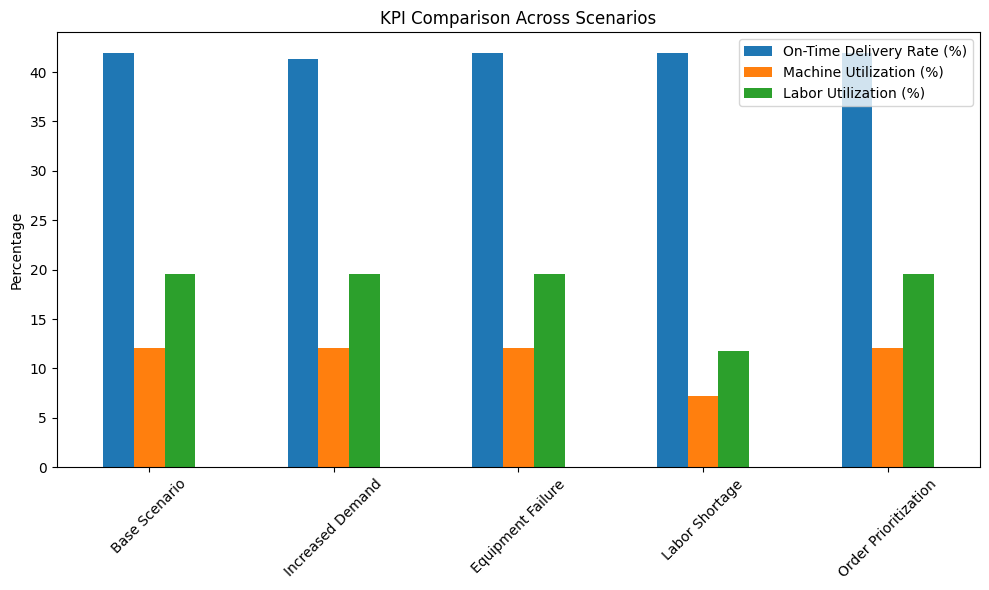

In [18]:
# Prepare data for visualization
kpi_names = ['on_time_delivery_rate', 'machine_utilization', 'labor_utilization'] 
kpi_labels = ['On-Time Delivery Rate (%)', 'Machine Utilization (%)', 'Labor Utilization (%)']

# Create a DataFrame for KPIs
kpi_data = pd.DataFrame({
    scenario_name: [kpis[kpi] for kpi in kpi_names]
    for scenario_name, (results, kpis) in all_scenario_results.items()
}, index=kpi_labels)

# Transpose for plotting
kpi_data = kpi_data.transpose()

# Plot KPIs
kpi_data.plot(kind='bar', figsize=(10, 6))
plt.title('KPI Comparison Across Scenarios')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()